<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Installation" data-toc-modified-id="Installation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Installation</a></span></li><li><span><a href="#Tutorial" data-toc-modified-id="Tutorial-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Tutorial</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Explore" data-toc-modified-id="Explore-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Explore</a></span></li><li><span><a href="#Compute" data-toc-modified-id="Compute-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Compute</a></span></li></ul></li></ul></div>

# 2D-SXDM tutorial

This notebook introduces basic exploration and preprocessing of 2D-SXDM data obatined on beamline ID01 @ ESRF using the in-house developed library `sxdm`. 

**Requirements**:
* An ESRF single sign-on (SSO)
* Basic knowledge of [Jupyter notebooks](https://jupyter.org/)

## Installation

This notebook is meant to be run on the [Jupyter-SLURM hub](https://jupyter-slurm.esrf.fr/). Instructions on how to achieve this are given in the [README](https://gitlab.esrf.fr/id01-science/id01-sxdm-utils/-/blob/main/README.md) of the `sxdm` repository (requires SSO for access). You should be reading this from within jupyter-slurm!

To run the notebook a few python dependecies are necessary. To simplify things, these are stored in a virtual environment accessible from jupyter-slurm and maintained by the ID01 staff. To install the virtual environment run the cell below:

In [ ]:
%%bash

pip3 install ipykernel
source /data/id01/inhouse/data_analysis/software/pyenvs/sxdm.slurm/bin/activate
python3 -m ipykernel install --user --name sxdm.slurm

Now refresh the webpage. One this is done, change the active kernel by using the menu bar on the top and clicking on `Kernel > Change kernel > sxdm.slurm`. You are now ready to run the notebook!

## Tutorial

### Introduction

2D-SXDM refers to SXDM data collected at a single angle, i.e. without rocking the sample. This corresponds to the output of individual `pscando` or `dpscando` commands run in `PSIC_NANO>` on ID01.

During an experiment data is saved on the ESRF NICE cluster. Each experiment has a directory tree dedicated to it. For example, the inhouse `blc12578` experiment is located in `/data/id01/inhouse/data/BLC/blc12578_zatterin/id01/`. This experiment investigated hillock-shaped defects in an AlGaN single crystal. Several sub-folder are present the folder:

In [1]:
%ls -lh /data/id01/inhouse/data/BLC/blc12578_zatterin/id01/

total 99K
drwxrwxrwx 4 opid01 id01 4.0K Jan 19  2022 analysis/
-rw-r--r-- 1 opid01 id01  90K Nov 21  2020 blc12578_zatterin-id01.h5
drwxrwxr-x 3 opid01 id01 4.0K Nov 21  2020 detector/
drwxrwxr-x 3 opid01 id01 4.0K Nov 21  2020 NCE_02885/
drwxrwxr-x 3 opid01 id01 4.0K Nov 21  2020 spec/
drwxrwxr-x 3 opid01 id01 4.0K Nov 21  2020 ss/


The folder `NCE_02885` corresponds to the name of a sample and was generated with the `ID01newsample` command on `PSIC_NANO>`. This command itself creates a directory tree for any given sample, isolating its data from the rest. The directory tree within this folder looks as follows:

In [2]:
!tree -L 2 /data/id01/inhouse/data/BLC/blc12578_zatterin/id01/NCE_02885

/data/id01/inhouse/data/BLC/blc12578_zatterin/id01/NCE_02885
└── KMAP_2020_11_21_231201
    ├── blc12578_zatterin-NCE_02885-KMAP_2020_11_21_231201.h5
    ├── detector
    ├── gallery
    └── spec

4 directories, 1 file


The sub-folder `KMAP_2020_11_21_231201` was generated by the command `ID01newdataset`. Its name contains a timestamp from when the command was run. Any scan run after such command was stored in this folder. The idea is to again isolate data stemming from something which, at the discretion of the user, can be though of as a "dataset", from the rest.

Of relevance within `KMAP_2020_11_21_231201` are:
* `detector`, containing the detector frames generated from scans;
* `spec`, containing:
    * `.spec` files, that store metadata from "normal" scans;
    * `_fast_xxxxx.spec` files, that store metadata from piezo (SXDM) scans.
    
For example,

In [3]:
%ls -lh /data/id01/inhouse/data/BLC/blc12578_zatterin/id01/NCE_02885/KMAP_2020_11_21_231201/spec/

total 132M
-rw-rw-r-- 1 opid01 id01 132M Nov 22  2020 KMAP_2020_11_21_231201_fast_00004.spec
-rw-rw-r-- 1 opid01 id01  32K Nov 23  2020 KMAP_2020_11_21_231201.spec


this dataset contains only two spec files. Of interest here is the `fast` one. To see what's inside it, load the `sxdm` library and a few others useful for computations later on in this notebook (it is good practice to place all imports at the beginning of a file):

In [4]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import sxdm

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


The `utils.get_filelist` function accepts a directory and looks for `fast` spec files into it. Passing to it the experiment directory,

In [5]:
data = sxdm.utils.get_filelist('/data/id01/inhouse/data/BLC/blc12578_zatterin/id01/')

One obtains a (here called) `data` object - a `pandas.DataFrame` - that in the jupyter notebook is rendered as a nice table containing useful info:

In [6]:
data

,path,filename,nscans
0,/data/id01/inhouse/data/BLC/blc12578_zatterin/...,ALIGNMENT_2020_11_21_205558_fast_00001.spec,2
1,/data/id01/inhouse/data/BLC/blc12578_zatterin/...,KMAP_2020_11_21_231201_fast_00004.spec,103


This allows to quickly sift through the collected data. Here we are interested in the spec file discussed above and containing 103 scans. Its full path is retrieved as:

In [7]:
path_to_specfile = data['path'][1]
print(path_to_specfile)

/data/id01/inhouse/data/BLC/blc12578_zatterin/id01/NCE_02885/KMAP_2020_11_21_231201/spec/KMAP_2020_11_21_231201_fast_00004.spec


### Explore

Now the file can then be opened like so:

In [9]:
fsf = sxdm.io.spec.FastSpecFile(path_to_specfile)

The `fsf` object thus gives access to the contents of `KMAP_2020_11_21_231201_fast_00004.spec`. A useful summary is obtained by simply calling it:

In [10]:
fsf

Filename,KMAP_2020_11_21_231201_fast_00004.spec
Number of scans,103
Datetime,Sat 2020/11/21 23:55:25


Note that `FastSpecFile` is a subclass of `silx.io.specfile.SpecFile`. See [its documentation](http://www.silx.org/doc/silx/latest/modules/io/specfile.html) to learn what other methods, applicable to any spec file (not just fast ones), are availble.

For a more insightful preview of the contents of `fsf`,  the object can be passed to the `RoiPlotter` widget. This plots the intensity falling in the interest (ROIs) that were defined during the experiment, and gives access to the position of all the motors defined within the spec session, as well as other details, when the scan was run. Interact with it!

In [12]:
explore_fsf = sxdm.widgets.spec.RoiPlotter(fsf)
explore_fsf.show()

The widget is useful also *during* an experiment to populate a logbook, as the static version of the plot can be accessed by:

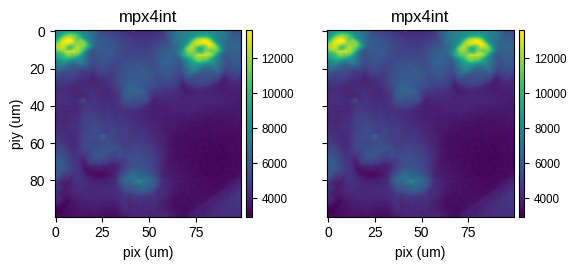

In [13]:
explore_fsf.fig

Right-clicking on the figure allows to copy it (and paste it in the logbook). The value of other objects within the wigdet can also be accessed in a similar way. A list of exposed methods is output by pressing tab after the dot, i.e. `explore_fsf.<TAB>`

Once a scan index of interest has been identified, it can be accessed from `fsf` using the `numpy` slicing syntax. Using scan number 25 as an example:

In [14]:
pscan = fsf[25]
pscan

Command,24 _pscando pix 5 95 300 piy 5 15 50 .01
Datetime,Sun 2020/11/22 02:32:40
Shape,"(50, 300)"


The [spec header identifier](http://www.silx.org/doc/silx/latest/modules/io/specfile.html) for this scan is in fact `24.2` since `24.1` was interrupted. All the identifiers can be accessed by calling `fsf.keys()`. The same scan can thus be accessed with the syntax:

In [15]:
pscan = fsf['24.2']
pscan

Command,24 _pscando pix 5 95 300 piy 5 15 50 .01
Datetime,Sun 2020/11/22 02:32:40
Shape,"(50, 300)"


The object `pscan` exposes methods to get all sorts of data and metadata pertaining the scan. Its docstring contains an explanation of each of them:

In [16]:
pscan?

For example, to get the value of a motor:

In [17]:
pscan.get_positioner('thz')

-1.9965

Or the data of a ROI defined during the experiment:

In [18]:
pscan.get_roidata('roi1')

array([[4056., 4163., 4270., ..., 4051., 4240., 3944.],
       [4297., 4346., 4209., ..., 4178., 4123., 4157.],
       [4261., 4256., 4307., ..., 4100., 4041., 4131.],
       ...,
       [4390., 4204., 4198., ..., 4308., 4250., 4287.],
       [4247., 4240., 4378., ..., 4315., 4246., 4398.],
       [4178., 4316., 4187., ..., 4358., 4342., 4535.]])

Let us know load a different scan (prettier for what done below):

In [19]:
pscan = fsf[5]
pscan

Command,5 _pscando pix 5 95 100 piy 5 95 100 .01
Datetime,Sun 2020/11/22 00:24:57
Shape,"(100, 100)"


To obtain an array containing all the detector frames collected at each sample position as part of the scan (takes some time due to data decompression):

In [20]:
frames = pscan.get_detector_frames()

Uncompressing data... Done in 27.91s


for scan 5 `frames` thus contains $100 \times 100$ detector frames, i.e.

In [21]:
frames.shape

(10000, 516, 516)

since the detector used was a MaxiPix, which has $516 \times 516$ pixels.

To see what each frame looks like at each sample position, use the `FramesExplorer` widget. Clicking around the scanned area, represented by the plot of one of the defined ROIs, loads the corresponiding frame. Have a go! Check the `Log Intensity` box to better observe any frame.

In [23]:
frame_explorer = sxdm.widgets.spec.FramesExplorer(pscan)
frame_explorer.show()

The `FramesExplorer` widget also allows to:
* Plot a different ROI
* Overlay the ROIs on the selected frame
* Define a new ROI by clicking and dragging, drawing a rectangle on the selected frame. The sum of all the intensity falling within such ROI, at each sample position, will then be used to update the ROI plot on the left.

As above, explore what can be extracted from the widget with `FramesExplorer.<TAB>`. For example, to get the last selected frame:

In [ ]:
frame_explorer.imgframe.get_array()

### Compute

Once:
1. A scan of interest has been identified, and
2. Its frames have been inspected to identifiy the interesting portion of such frames (i.e. that where there is signal - in SXDM scan most of the detector is often empty!)

one can proceed to compute the centre of mass (COM) of each of such frames. To do so:

In [ ]:
cy, cz = pscan.calc_coms(roi=[204,249,311,339])

Note that specifying the `roi` argument is not required but speeds up calculations significantly.

> Once we switch to hdf5 files as data storage this will not be an issue anymore as computations can be done on multiple CPU cores parallely.

These COMs are given in detector pixel coordinates: 

In [ ]:
pix, piy = pscan.get_piezo_coordinates() # load piezo scan coordinates
pi_ext = sxdm.utils.get_pi_extents(pix, piy, None) # compute their extents for the plotting

fig, ax = plt.subplots(1,2, sharey=True, figsize=(6,2.8), dpi=150, layout='tight')

ax[0].imshow(cz, extent=pi_ext)
ax[1].imshow(cy, extent=pi_ext)

ax[0].set_ylabel('piy (um)')
ax[0].set_title('COM_z')
ax[1].set_title('COM_y')

for a in ax:
    a.set_xlabel('pix (um)')
    _ = sxdm.plot.add_colorbar(a, a.get_images()[0])

To obtain them in the more useful q-space coordinates, first compute them like so:

In [ ]:
qx, qy, qz = pscan.calc_qspace_coordinates()

See the docstring of `calc_qspace_coordinates()` to see how to override standard parameters should this be necessary.
A small digression is useful at this point. Recall that on ID01 $q_x$ is defined to be along the beam, while $q_y$ is pointing radially away from the synchrotron. Since this scan was taken at:

In [ ]:
phi, nu = [pscan.get_positioner(x) for x in ('phi', 'nu')]

print(f'phi={phi:.3f}, nu={nu:.3f}')

TODO - maybe put it later to show how to apply offsets

In [ ]:
off = pscan.qconversion_motors_offsets

off['phi'] = 3.7
off['nu'] = 0.85

qx, qy, qz = pscan.calc_qspace_coordinates()

The slice of reciprocal space being probed by the detector is close to, but not quite, being paralell to $q_y$. This can be visualised by plotting the sum of all frames in q-space coordinates:

In [ ]:
frame_sum = frames.sum(0).astype('int32')

In [ ]:
color_map = plt.get_cmap('magma')
I = color_map(frame_sum)

fig = plt.figure(layout='tight')
ax = fig.add_subplot(projection='3d')

ax.plot_surface(qx, qy, qz, facecolors=I)

ax.set_xlabel(r'$q_x~(\AA^{-1})$')
ax.set_ylabel(r'$q_y~(\AA^{-1})$')
ax.set_zlabel(r'$q_z~(\AA^{-1})$')

Going back to the COM determination, COMs can be calculated in q-space coordinates:

**TODO**

In [ ]:
cqx, cqy, cqz = pscan.calc_coms(roi=[204,249,311,339], qspace=True)

In [ ]:
pix, piy = pscan.get_piezo_coordinates() # load piezo scan coordinates
pi_ext = sxdm.utils.get_pi_extents(pix, piy, None) # compute their extents for the plotting

fig, ax = plt.subplots(1,3, sharey=True, figsize=(8,3), dpi=120, layout='tight')

ax[0].imshow(cqx, extent=pi_ext)
ax[1].imshow(cqy, extent=pi_ext)
ax[2].imshow(cqz, extent=pi_ext)

ax[0].set_ylabel('piy (um)')

for a in ax:
    a.set_xlabel('pix (um)')
    _ = sxdm.plot.add_colorbar(a, a.get_images()[0])

In [ ]:
cqx, cqy, cqz, stdx, stdy, stdz = pscan.calc_coms(roi=[204,249,311,339], qspace=True, calc_std=True)

In [ ]:
pix, piy = pscan.get_piezo_coordinates() # load piezo scan coordinates
pi_ext = sxdm.utils.get_pi_extents(pix, piy, None) # compute their extents for the plotting

fig, ax = plt.subplots(1,3, sharey=True, figsize=(8,3), dpi=120, layout='tight')

ax[0].imshow(stdx, extent=pi_ext)
ax[1].imshow(stdy, extent=pi_ext)
ax[2].imshow(stdz, extent=pi_ext)

ax[0].set_ylabel('piy (um)')

for a in ax:
    a.set_xlabel('pix (um)')
    _ = sxdm.plot.add_colorbar(a, a.get_images()[0])

These q-space COM coordinates finally allow one to compute the local interplanar distance $d_{025}$ (since this is a 025 peak) and the tilt from the $q_z$ axis using linear algebra and spherical coordinates: 

In [ ]:
# q-vector magnitudes
q = np.sqrt(cqx**2 + cqy**2 + cqz**2)
q_ref = 1

# q-vector coordinates
Q = np.array([cqx, cqy, cqz])
Q_ref = np.array([0,0,1])

# compute angle between Q and Q_ref
_num = np.dot(Q_ref, Q.flatten().reshape(3, q.size))
_denom = q.flatten() * q_ref

tiltmag = np.degrees(np.arccos(_num / _denom))
tiltmag = tiltmag.reshape(q.shape)

# compute azimuthal distance between Q and Q_ref
az = np.degrees(np.arctan2(cqy, cqz)) 

# get plot-friendly tilt
tilt = sxdm.plot.make_hsv(tiltmag, az, stretch=True)

# interplanar distance
d = 4 * np.pi / q

If one plots such values,

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

pix, piy = pscan.get_piezo_coordinates() # load piezo scan coordinates
pi_ext = sxdm.utils.get_pi_extents(pix, piy, None) # compute their extents for the plotting

fig, ax = plt.subplots(1,2, sharey=True, figsize=(6,2.8), dpi=150, layout='tight')

ax[0].imshow(tilt, extent=pi_ext)
ax[1].imshow(d, extent=pi_ext)

## ax[0] colorbar
a, b = np.meshgrid(np.linspace(0,1,100), np.linspace(-180,180,100))
cmap = sxdm.plot.make_hsv(a,b)

cax = make_axes_locatable(ax[0]).append_axes('right', size='20%', pad=0.05)
cax.imshow(cmap, aspect='auto')

cax.tick_params(labelsize='small', left=False, right=True, labelleft=False, labelright=True)
cax.locator_params(axis='y', tight=True, nbins=7)

cax.set_yticks([0,25,50,75,99,])
cax.set_yticklabels([-180,-90,0,90,180])

cax.set_xticks([0,99])
cax.set_xticklabels(f'{tiltmag.min():.4f},{tiltmag.max():.4f}'.split(','), rotation=40)

cax.yaxis.set_label_position("right")
cax.set_ylabel(r'Tilt azimuth $(\degree)$', labelpad=1, fontsize='small')
cax.set_xlabel(r'Tilt magnitude $(\degree)$', labelpad=1, fontsize='small')

# labels etc
ax[0].set_title('Tilt', pad=15)
ax[1].set_title('$d_{025}$', pad=15)

_ = sxdm.plot.add_colorbar(ax[1], ax[1].get_images()[0])

ax[0].set_ylabel('piy (um)')
_ = [a.set_xlabel('pix (um)') for a in ax]

It is seen that the tilt azimuth is always close to $0^{\circ}$, as expected from the fact that the probed peak plane is always almost parallel to $q_y$ (think about it!). Despite the pixelation and the lack of resolution along $q_x$, these plots already suggest that the hillock-shaped defects rotate the AlGaN lattice in the direction of the hillock surface, as one might expect.